# Video Game Sales Prediction

## Part 0: Introduction

This dataset, inspired by Gregory Smith's web scrape of VGChartz, extends video game sales data with additional variables sourced from Metacritic. It includes information on game sales by region, critic and user scores, and game metadata such as platform, genre, and ESRB ratings. 

### Objective: To create a classification model that can predict the global sale of a video game (Note the target column in the dataset is Global_Sales)

We will follow the following steps:
1. Read the Data
2. Reduce the data by
   - Removing duplicates
   - 


# Imports

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading and Understanding the DataSet

In [235]:
file_path = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
df = pd.read_csv(file_path)

df.shape

(16719, 16)

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


# Data Preprocessing

In [238]:
columns_to_drop = ['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Count', 'User_Count']

# Drop the columns from the dataset
df = df.drop(columns=columns_to_drop, axis=1)

# Verify the columns were correctly dropped
df.shape

(16719, 9)

Dropped Name, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Critic_Count, and User_Count as we are focused on predicting the global sales and want to test how Platform, Year of Release, Genre, Publisher, Critic Score, User Score, Developer, and Rating affect the global sales. 

In [240]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)


Percentage of missing values per column:
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
Global_Sales        0.000000
Critic_Score       51.330821
User_Score         40.098092
Developer          39.613613
Rating             40.486871
dtype: float64


In [241]:
df.dropna(inplace=True)
df.isnull().sum()
df.shape

(7877, 9)

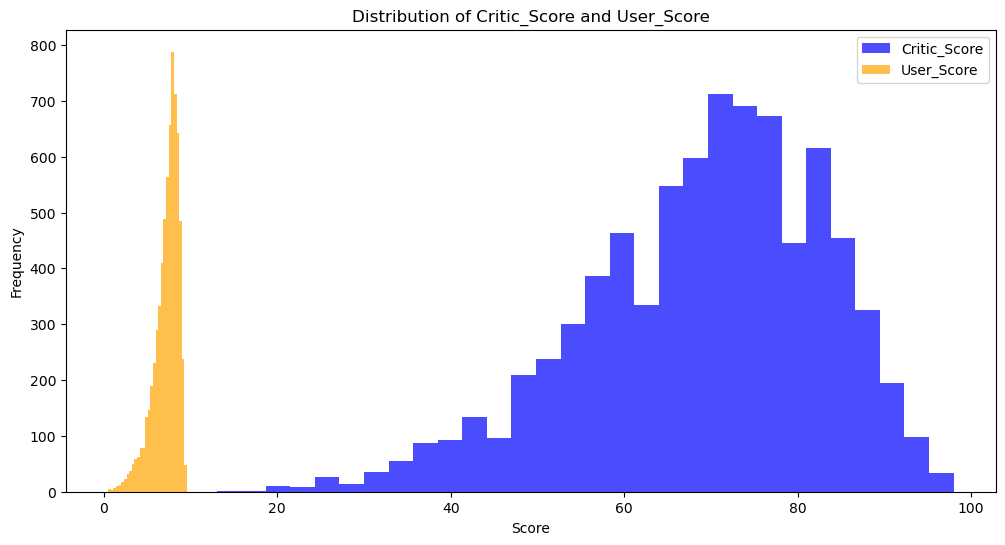

In [242]:
# Visualize the distribution of Critic_Score and User_Score to decide how to fill in the missing values
plt.figure(figsize=(12, 6))
plt.hist(df['Critic_Score'].dropna(), bins=30, color='blue', alpha=0.7, label='Critic_Score')
plt.hist(pd.to_numeric(df['User_Score'], errors='coerce').dropna(), bins=30, color='orange', alpha=0.7, label='User_Score')
plt.title('Distribution of Critic_Score and User_Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Based on the distribution of data, using the median would be a good choice. 

In [244]:
# Impute missing `Critic_Score` and `User_Score` with the median
df['Critic_Score'] = df['Critic_Score'].fillna(df['Critic_Score'].median())
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')  # Convert "tbd" to NaN
df['User_Score'] = df['User_Score'].fillna(df['User_Score'].median())

# Handle categorical `Rating` by filling with the mode
df['Rating'] = df['Rating'].fillna(df['Rating'].mode()[0])

# Drop rows with missing `Year_of_Release`, `Genre`, and `Publisher`
df = df.dropna(subset=['Year_of_Release', 'Genre', 'Publisher'])

# Verify changes in the dataset
print("\nDataset info after handling missing values and dropping rows:")
df.info()
df.shape
df.head()


Dataset info after handling missing values and dropping rows:
<class 'pandas.core.frame.DataFrame'>
Index: 7877 entries, 0 to 16706
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         7877 non-null   object 
 1   Year_of_Release  7877 non-null   float64
 2   Genre            7877 non-null   object 
 3   Publisher        7877 non-null   object 
 4   Global_Sales     7877 non-null   float64
 5   Critic_Score     7877 non-null   float64
 6   User_Score       7877 non-null   float64
 7   Developer        7877 non-null   object 
 8   Rating           7877 non-null   object 
dtypes: float64(4), object(5)
memory usage: 615.4+ KB


,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,User_Score,Developer,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,8.0,Nintendo,E
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,8.3,Nintendo,E
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,8.0,Nintendo,E
6,DS,2006.0,Platform,Nintendo,29.80,89.0,8.5,Nintendo,E
7,Wii,2006.0,Misc,Nintendo,28.92,58.0,6.6,Nintendo,E


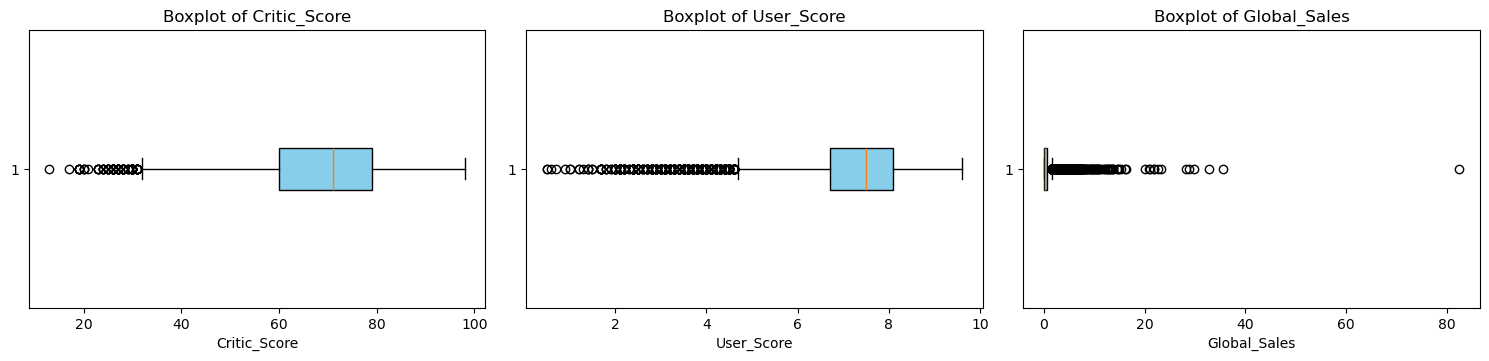

(7877, 9)

In [245]:
# List of numerical columns to check for outliers
numerical_columns = ['Critic_Score', 'User_Score', 'Global_Sales']

# Generate boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, start=1):
    if col in df.columns:
        plt.subplot(3, 3, i)  # Create subplots (3 rows x 3 columns for 9 plots)
        plt.boxplot(df[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
plt.tight_layout()
plt.show()
df.shape

In [246]:
# Remove outliers for Critic_Score
df = df[(df['Critic_Score'] >= 20) & (df['Critic_Score'] <= 100)]

# Remove outliers for Global_Sales
df = df[df['Global_Sales'] <= 80]

# Verify dataset after removing outliers
print("\nDataset info after removing outliers:")
df.info()

df.shape


Dataset info after removing outliers:
<class 'pandas.core.frame.DataFrame'>
Index: 7868 entries, 2 to 16706
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         7868 non-null   object 
 1   Year_of_Release  7868 non-null   float64
 2   Genre            7868 non-null   object 
 3   Publisher        7868 non-null   object 
 4   Global_Sales     7868 non-null   float64
 5   Critic_Score     7868 non-null   float64
 6   User_Score       7868 non-null   float64
 7   Developer        7868 non-null   object 
 8   Rating           7868 non-null   object 
dtypes: float64(4), object(5)
memory usage: 614.7+ KB


(7868, 9)